In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import simim.siminterface as sim

tng100 = sim.SimHandler('TNG100-1')

rng = np.random.default_rng(1511)

pixel_size = tng100.box_edge_no_h / 450
z_for_modeling = 1.0
tng100_snap = tng100.get_snap_from_z(z_for_modeling)

bins = np.logspace(-3,3,z21)
bin_centers = (bins[1:] + bins[:-1]) / 2
k = 2*np.pi * bin_centers

In [2]:
from simim import constants as sc
from simim.galprops import prop_behroozi_sfr, prop_delooze_cii

tng100_snap.make_property(prop_behroozi_sfr, other_kws={'rng': rng}, overwrite=True, rename='sfr_behroozi')
tng100_snap.make_property(prop_delooze_cii, other_kws={'rng': rng}, overwrite=True, rename='LCII', kw_remap={'sfr': 'sfr_behroozi'})

d = tng100_snap.cosmo.comoving_distance(z_for_modeling).value
yfactor = sc.c / sc.nu_cii * (1+z_for_modeling)**2 / (1000*tng100_snap.cosmo.H(z_for_modeling).value)
dl = (1+z_for_modeling)*d

convnucii = sc.Lsun_to_W / (4*np.pi*dl**2) * d**2 * yfactor / pixel_size**3 \
    * 1 / 3.0857e22**2 *1e26 # Convert to Jy/sr from Lsun/Mpc^3

grid_CII = tng100_snap.grid('LCII', res=pixel_size, norm=convnucii)

ps_CII = grid_CII.power_spectrum(in_place=False,normalize=True)

# Spherical average
_,ps1d = ps_CII.spherical_average(ax=[0,1,2],shells=bins)
ps1d_CII = ps1d[:,0] / np.prod(grid_CII.side_length)  # Normalize by volume

/Users/shubh/Library/CloudStorage/OneDrive-PennO365/TIM/crossLIM/simim_public/simim/_handlers.py:312: UserWarning: Property sfr_behroozi already exists, overwriting
  warnings.warn("Property {} already exists, overwriting".format(name))
/Users/shubh/Library/CloudStorage/OneDrive-PennO365/TIM/crossLIM/simim_public/simim/_handlers.py:312: UserWarning: Property LCII already exists, overwriting
  warnings.warn("Property {} already exists, overwriting".format(name))
/Users/shubh/Library/CloudStorage/OneDrive-PennO365/TIM/crossLIM/simim_public/simim/map/gridder.py:1753: RuntimeWarning: invalid value encountered in divide
  binned_averages /= binned_weights


In [ ]:
from simim.galprops import Prop, prop_li_hi, prop_mass_hi
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u, constants as con

nu21rest = 1.420405751e9  # Hz
nu21obs = nu21rest / (1 + z_for_modeling)  # Hz
conv_mK = 1e3 * (sc.c**2 / (2 * con.k_B * nu21obs**2)).to(u.K/u.J).value * 1e-26  # Jy/sr to mK

d = tng100_snap.cosmo.comoving_distance(z_for_modeling).value
yfactor = sc.c / nu21rest * (1+z_for_modeling)**2 / (1000*tng100_snap.cosmo.H(z_for_modeling).value)
dl = (1+z_for_modeling)*d

conv21 = sc.Lsun_to_W / (4*np.pi*dl**2) * d**2 * yfactor / pixel_size**3 \
    * 1 / 3.0857e22**2 *1e26

tng100_snap.make_property(prop_mass_hi, other_kws={'rng': rng, 'cosmo': cosmo}, overwrite=True)
tng100_snap.make_property(prop_li_hi, overwrite=True)

grid_HI = tng100_snap.grid('LHI', res=pixel_size, norm=conv21 * conv_mK)

ps_HI = grid_HI.power_spectrum(in_place=False,normalize=True)

# Spherical average
_,ps1d = ps_HI.spherical_average(ax=[0,1,2],shells=bins)
ps1d_HI = ps1d[:,0] / np.prod(grid_HI.side_length)  # Normalize by volume

In [4]:
crosspsHI = grid_CII.power_spectrum(cross_grid=grid_HI, in_place=False, normalize=True)

_,ps1d = crosspsHI.spherical_average(ax=[0,1,2],shells=bins)
ps1d_crossHI = ps1d[:,0] / np.prod(grid_CII.side_length)  # Normalize by volume

In [5]:
from simim.galprops import prop_co_sled
from simim import constants as sc

tng100_snap.make_property(prop_co_sled, other_kws={'rng': rng, 'fircor':0.6}, overwrite=True, kw_remap={'sfr': 'sfr_behroozi'})

nu_co = sc.nu_co43
lco = 'L43'

d = tng100_snap.cosmo.comoving_distance(z_for_modeling).value
yfactor = sc.c / nu_co * (1+z_for_modeling)**2 / (1000*tng100_snap.cosmo.H(z_for_modeling).value)
dl = (1+z_for_modeling)*d
convnuco = sc.Lsun_to_W / (4*np.pi*dl**2) * d**2 * yfactor / pixel_size**3 \
    * 1 / 3.0857e22**2 *1e26 # Convert to Jy/sr from Lsun/Mpc^3

grid_CO = tng100_snap.grid(lco, res=pixel_size, norm=convnuco)

ps_CO = grid_CO.power_spectrum(in_place=False,normalize=True)

# Spherical average
_,ps1d = ps_CO.spherical_average(ax=[0,1,2],shells=bins)
ps1d_CO = ps1d[:,0] / np.prod(grid_CO.side_length)  # Normalize by volume

/Users/shubh/Library/CloudStorage/OneDrive-PennO365/TIM/crossLIM/simim_public/simim/_handlers.py:312: UserWarning: Property L21 already exists, overwriting
  warnings.warn("Property {} already exists, overwriting".format(name))


In [6]:
crosspsCO = grid_CII.power_spectrum(cross_grid=grid_CO, in_place=False, normalize=True)

_,ps1d = crosspsCO.spherical_average(ax=[0,1,2],shells=bins)
ps1d_crossCO = ps1d[:,0] / np.prod(grid_CII.side_length)  # Normalize by volume

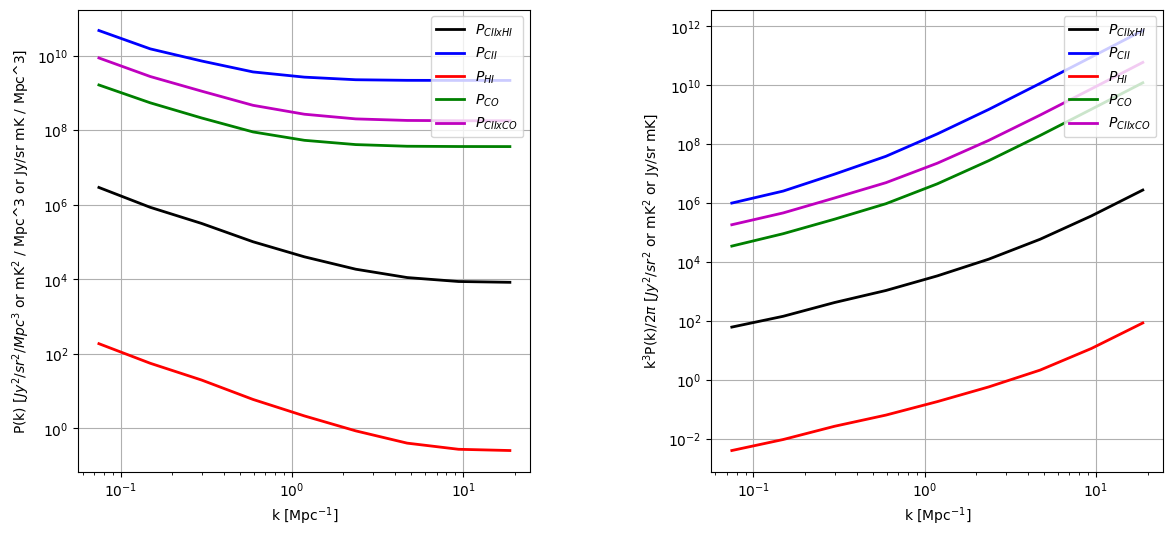

In [7]:
# Plot the results
fig,ax = plt.subplots(1,2,figsize=(14,6),sharex=True)
fig.subplots_adjust(wspace=.4)
ax[0].set(xlabel='k [Mpc$^{-1}$]',ylabel='P(k) [$Jy^2/sr^2/Mpc^3$ or mK$^2$ / Mpc^3 or Jy/sr mK / Mpc^3]',xscale='log',yscale='log')
ax[0].grid()
ax[1].set(xlabel='k [Mpc$^{-1}$]',ylabel='k$^3$P(k)/2$\pi$ [$Jy^2/sr^2$ or mK$^2$ or Jy/sr mK]',xscale='log',yscale='log')
ax[1].grid()

ax[0].plot(k,ps1d_crossHI,lw=2,color='k', label='$P_{CII x HI}$')
ax[1].plot(k,k**3/2/np.pi**2*ps1d_crossHI,lw=2,color='k', label='$P_{CII x HI}$')
ax[0].plot(k,ps1d_CII,lw=2,color='b', label='$P_{CII}$')
ax[1].plot(k,k**3/2/np.pi**2*ps1d_CII,lw=2,color='b', label='$P_{CII}$')
ax[0].plot(k,ps1d_HI,lw=2,color='r', label='$P_{HI}$')
ax[1].plot(k,k**3/2/np.pi**2*ps1d_HI,lw=2,color='r', label='$P_{HI}$')
ax[0].plot(k,ps1d_CO,lw=2,color='g', label='$P_{CO}$')
ax[1].plot(k,k**3/2/np.pi**2*ps1d_CO,lw=2,color='g', label='$P_{CO}$')
ax[0].plot(k,ps1d_crossCO,lw=2,color='m', label='$P_{CII x CO}$')
ax[1].plot(k,k**3/2/np.pi**2*ps1d_crossCO,lw=2,color='m', label='$P_{CII x CO}$')


ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')

# plt.savefig('../figs/cross_ps.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

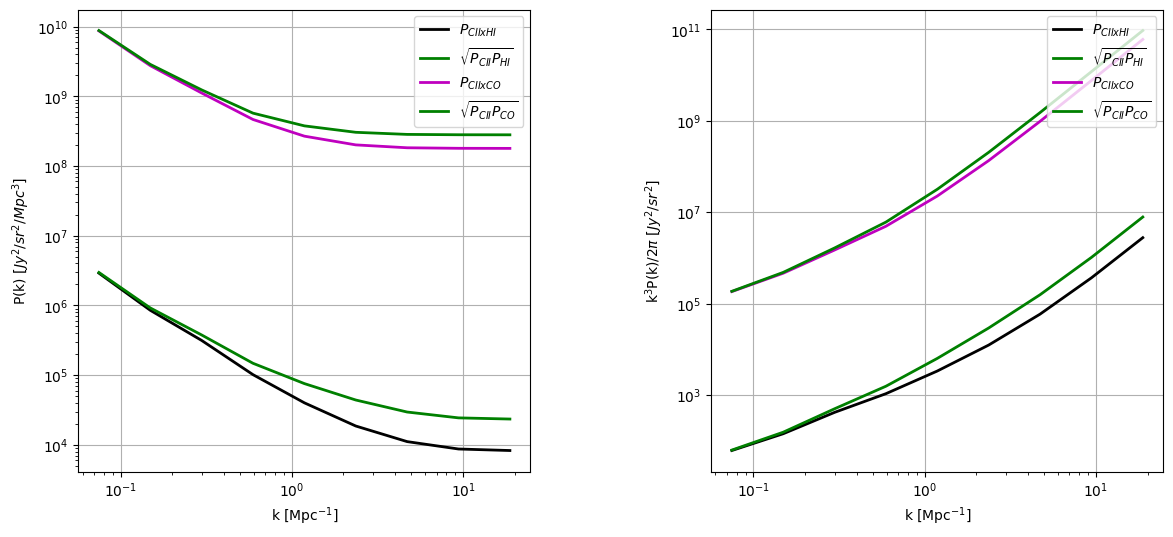

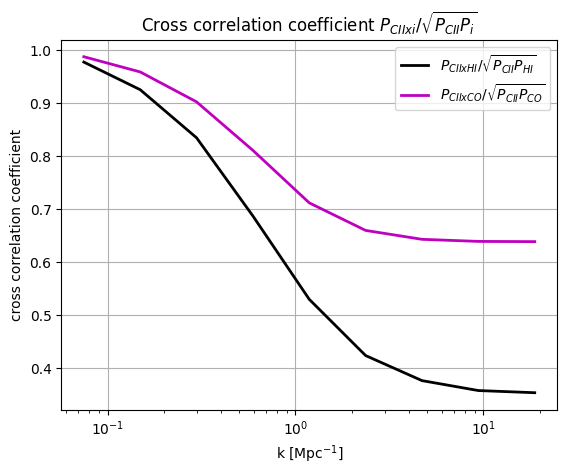

In [8]:
# Plot the results
fig,ax = plt.subplots(1,2,figsize=(14,6),sharex=True)
fig.subplots_adjust(wspace=.4)
ax[0].set(xlabel='k [Mpc$^{-1}$]',ylabel='P(k) [$Jy^2/sr^2/Mpc^3$]',xscale='log',yscale='log')
ax[0].grid()
ax[1].set(xlabel='k [Mpc$^{-1}$]',ylabel='k$^3$P(k)/2$\pi$ [$Jy^2/sr^2$]',xscale='log',yscale='log')
ax[1].grid()

ax[0].plot(k,ps1d_crossHI,lw=2,color='k', label='$P_{CII x HI}$')
ax[1].plot(k,k**3/2/np.pi**2*ps1d_crossHI,lw=2,color='k', label='$P_{CII x HI}$')
prod_ps_HI = np.sqrt(ps1d_CII * ps1d_HI)
ax[0].plot(k,prod_ps_HI,lw=2,color='g', label='$\sqrt{P_{CII}P_{HI}}$')
ax[1].plot(k,k**3/2/np.pi**2*prod_ps_HI,lw=2,color='g', label='$\sqrt{P_{CII}P_{HI}}$')

ax[0].plot(k,ps1d_crossCO,lw=2,color='m', label='$P_{CII x CO}$')
ax[1].plot(k,k**3/2/np.pi**2*ps1d_crossCO,lw=2,color='m', label='$P_{CII x CO}$')
prod_ps_CO = np.sqrt(ps1d_CII * ps1d_CO)
ax[0].plot(k,prod_ps_CO,lw=2,color='g', label='$\sqrt{P_{CII}P_{CO}}$')
ax[1].plot(k,k**3/2/np.pi**2*prod_ps_CO,lw=2,color='g', label='$\sqrt{P_{CII}P_{CO}}$')

ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')

plt.show()
plt.close()

plt.figure()
plt.plot(k,ps1d_crossHI/prod_ps_HI,lw=2,color='k', label='$P_{CII x HI} / \sqrt{P_{CII}P_{HI}}$')
plt.plot(k,ps1d_crossCO/prod_ps_CO,lw=2,color='m', label='$P_{CII x CO} / \sqrt{P_{CII}P_{CO}}$')
plt.xscale('log')
plt.grid()
plt.xlabel('k [Mpc$^{-1}$]')
plt.ylabel('cross correlation coefficient')
plt.title('Cross correlation coefficient $P_{CII x i} / \sqrt{P_{CII}P_{i}}$')
plt.legend()
# plt.savefig('../figs/cross_coeff.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [9]:
x, y, z = tng100_snap.return_property('pos_x'), tng100_snap.return_property('pos_y'), tng100_snap.return_property('pos_z')
LCII, LHI, L43 = tng100_snap.return_property('LCII'), tng100_snap.return_property('LHI'), tng100_snap.return_property('L43')

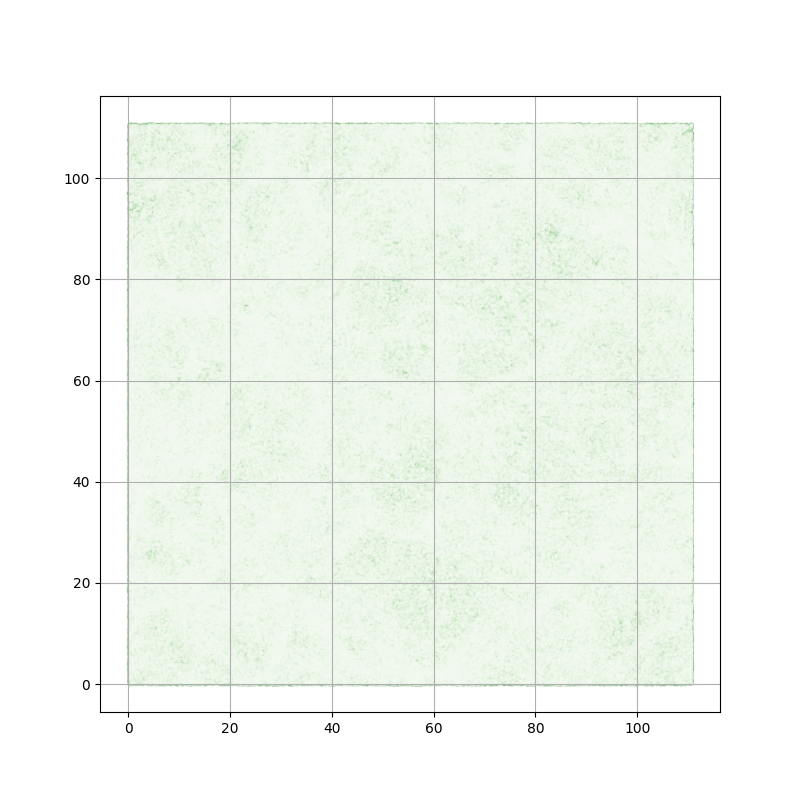

In [12]:
%matplotlib ipympl

mask = (z > 1) & (z < 2) #& (x > 45) & (x < 46) & (y > 91) & (y < 92)

maskLCII = LCII > np.median(LCII)
maskLHI = LHI > np.median(LHI)
maskL43 = L43 > np.median(L43)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.grid()

ax.scatter(x[maskL43], y[maskL43], c=np.log10(L43[maskL43]), s=1, cmap='Blues', alpha=0.3, marker='s')
ax.scatter(x[maskLCII], y[maskLCII], c=np.log10(LCII[maskLCII]), s=1, cmap='Reds', alpha=0.3, marker='s')
ax.scatter(x[maskLHI], y[maskLHI], c=np.log10(LHI[maskLHI]), s=1, cmap='Greens', alpha=0.3, marker='s')
plt.show()
# plt.close()

In [ ]:
from simim.lightcone import LCMaker, LCHandler

gen = LCMaker(sim='TNG100-1',
              name='cii_hi',
              openangle=1.0,
              aspect=1.0,
              mode = 'box',
              redshift_min = 0.5,
              redshift_max = 1.7,
              minimum_mass = 1e8)

gen.build_lightcones(rng=rng)
gen.add_properties('I_HI','LCII')

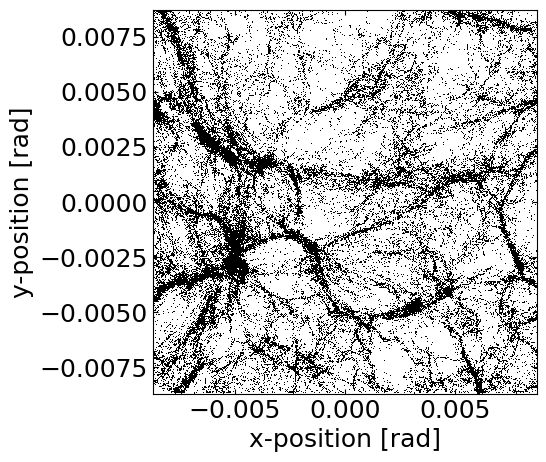

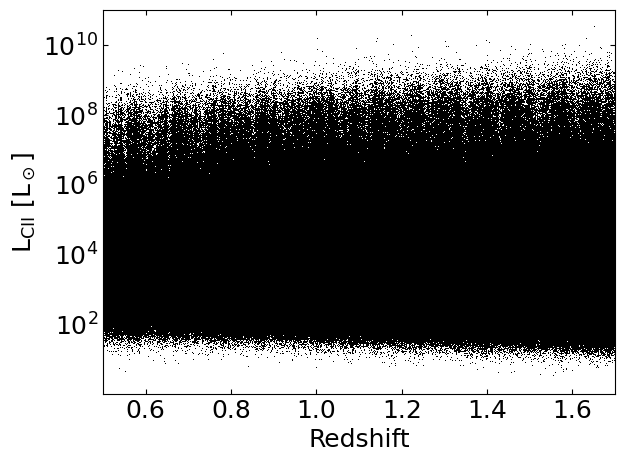

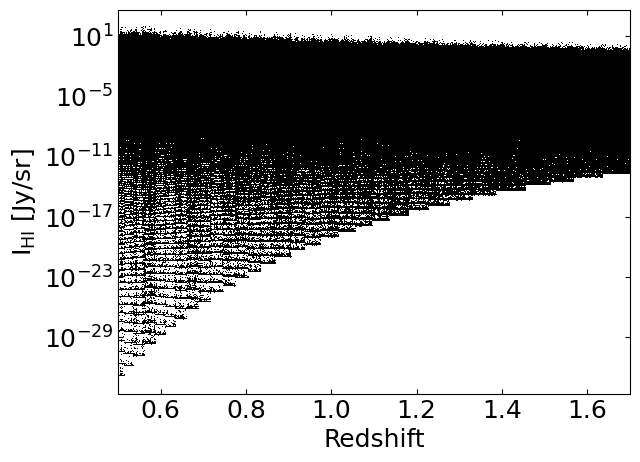

In [ ]:
lc1 = LCHandler('TNG100-1','cii_hi',0)

lc1.set_property_range('redshift',0.999,1.001)
lc1.plot('ra','dec',
         axkws={'xlabel':'x-position [rad]','ylabel':'y-position [rad]','aspect':'equal','xlim':(-0.5*np.pi/180,0.5*np.pi/180),'ylim':(-0.5*np.pi/180,0.5*np.pi/180)},
         plotkws={'marker':',','color':'k'})

lc1.set_property_range()
lc1.plot('redshift','LCII',
         axkws={'xlabel':'Redshift','ylabel':'L$_\mathregular{CII}$ [L$_\odot$]','xlim':(0.5,1.7),'yscale':'log'},
         plotkws={'marker':',','color':'k'})

lc1.set_property_range()
lc1.plot('redshift','I_HI',
         axkws={'xlabel':'Redshift','ylabel':'I$_\mathregular{HI}$ [Jy/sr]','xlim':(0.5,1.7),'yscale':'log'},
         plotkws={'marker':',','color':'k'})

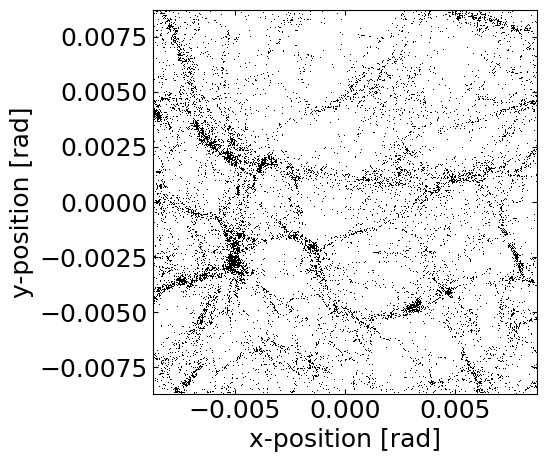

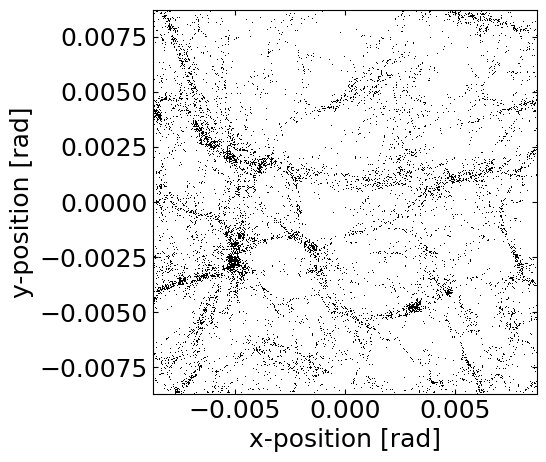

In [ ]:
lc1.set_property_range("LCII", 1e4, 1e10)
lc1.set_property_range('redshift',0.999,1.001, reset=False)
lc1.plot('ra','dec',
         axkws={'xlabel':'x-position [rad]','ylabel':'y-position [rad]','aspect':'equal','xlim':(-0.5*np.pi/180,0.5*np.pi/180),'ylim':(-0.5*np.pi/180,0.5*np.pi/180)},
         plotkws={'marker':',','color':'k'})

lc1.set_property_range("I_HI", 1e-3, 1e5)
lc1.set_property_range('redshift',0.999,1.001, reset=False)
lc1.plot('ra','dec',
         axkws={'xlabel':'x-position [rad]','ylabel':'y-position [rad]','aspect':'equal','xlim':(-0.5*np.pi/180,0.5*np.pi/180),'ylim':(-0.5*np.pi/180,0.5*np.pi/180)},
         plotkws={'marker':',','color':'k'})